# Deteksi Anomali menggunakan semi supervised learning

## Import Libraries and Dataset

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Unsupervised (Machine) Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Metrics (distance) and stats
from scipy.spatial.distance import euclidean
from scipy.stats import median_abs_deviation

# Visualize in a two-dimensional space
from sklearn.decomposition import PCA

# Ignore warnings (only for presentation)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/April/Downloads/machine_temperature_system_failure.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


observasi:
data set terdiri dari 22695 data. 
kita perlu melakukan feature engineering pada kolom timestamp,
kolom value berisi data dengan tipe float

In [4]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


Obervasi = 

1.   Nilai temperature mesin pada dataset dalam fahrenheit  
2.   temperatur mesin paling rendah mencapai 2.08 derajat fahrenheit, dan nilai paling tinggi mencapai 108 derajat fahrenheit



In [5]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


## EDA and Preprocessing

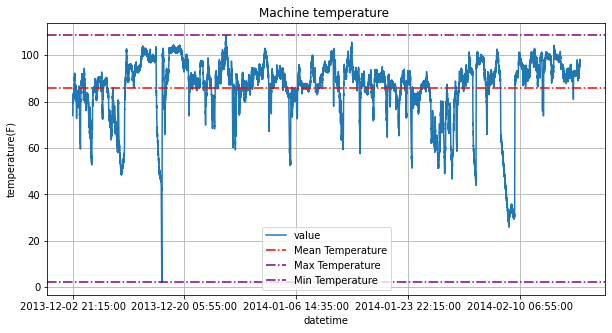

In [6]:
#Visualize the data
figsize=(10,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.axhline(y = df['value'].mean(), color = 'red', linestyle = 'dashdot',label='Mean Temperature')
plt.axhline(y = df['value'].max(), color = 'purple', linestyle = 'dashdot',label='Max Temperature')
plt.axhline(y = df['value'].min(), color = 'purple', linestyle = 'dashdot',label='Min Temperature')
plt.xlabel('datetime')
plt.ylabel('temperature(F)')
plt.legend()
plt.title('Machine temperature ')
plt.grid();
plt.show();

### Preprocessing

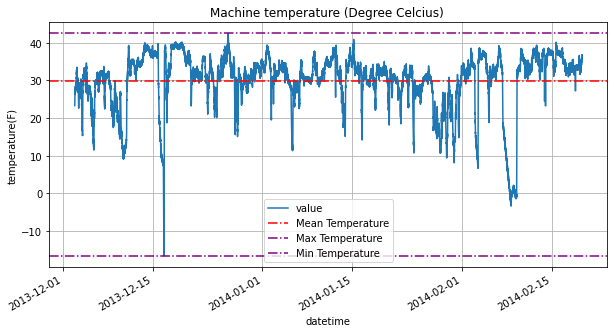

In [7]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.axhline(y = df['value'].mean(), color = 'red', linestyle = 'dashdot',label='Mean Temperature')
plt.axhline(y = df['value'].max(), color = 'purple', linestyle = 'dashdot',label='Max Temperature')
plt.axhline(y = df['value'].min(), color = 'purple', linestyle = 'dashdot',label='Min Temperature')
plt.xlabel('datetime')
plt.ylabel('temperature(F)')
plt.legend()
plt.title('Machine temperature (Degree Celcius) ')
plt.grid();
plt.show();

In [8]:
#Detailing date time

df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)
df['dayofweek'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.weekday())

In [9]:
df['daylight'] = ((df['hour']>=7) & (df['hour']<=22)).astype(int)
df['weekday'] = (df['dayofweek'] < 5).astype(int)

In [10]:
df['time_epoch']= (df['timestamp'].view(np.int64)/100000000000).astype(np.int64)

In [11]:
## creation of 4 distinct categories for insight (week end/day week & night/day)
df['categories'] = df['weekday']*2+df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

In [12]:
df.head()

,timestamp,value,year,month,day,hour,minute,dayofweek,daylight,weekday,time_epoch,categories
0,2013-12-02 21:15:00,23.315179,2013,12,2,21,15,0,1,1,13860189,3
1,2013-12-02 21:20:00,23.853268,2013,12,2,21,20,0,1,1,13860192,3
2,2013-12-02 21:25:00,24.513423,2013,12,2,21,25,0,1,1,13860195,3
3,2013-12-02 21:30:00,25.633726,2013,12,2,21,30,0,1,1,13860198,3
4,2013-12-02 21:35:00,26.294353,2013,12,2,21,35,0,1,1,13860201,3


In [13]:
df['weekday'].value_counts()

1    16359
0     6336
Name: weekday, dtype: int64

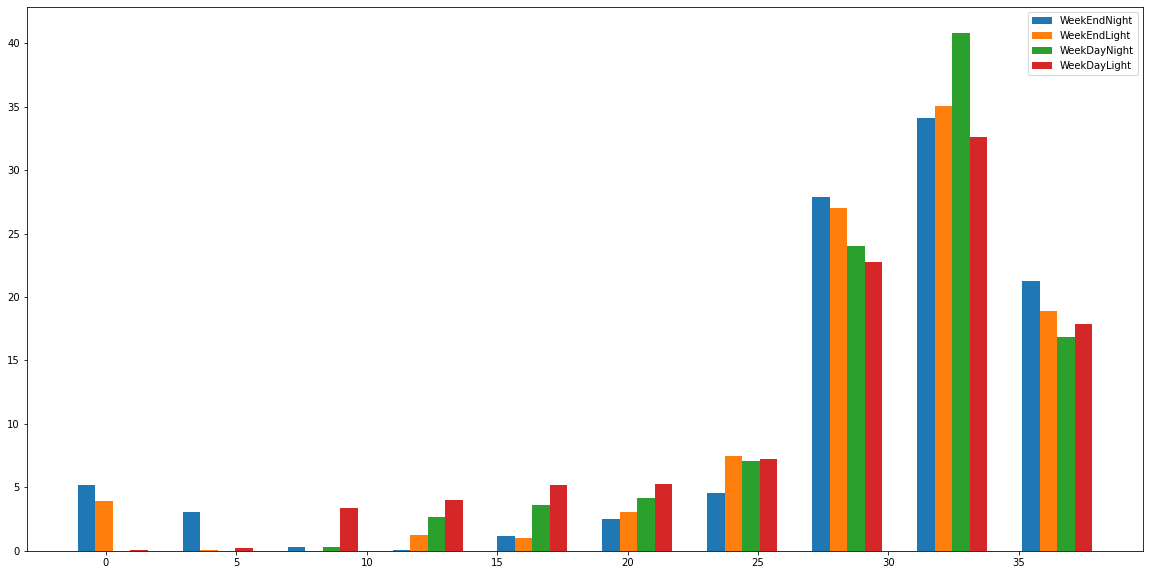

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, label ='WeekDayLight')

plt.legend()
plt.show()

Observasi:
Temperatur machine lebih stabil saat weekday daylight

In [15]:
df.sample(3)

,timestamp,value,year,month,day,hour,minute,dayofweek,daylight,weekday,time_epoch,categories
9238,2014-01-03 23:05:00,33.310886,2014,1,3,23,5,4,0,1,13887903,2
8417,2014-01-01 02:40:00,33.616463,2014,1,1,2,40,2,0,1,13885440,2
4693,2013-12-19 04:20:00,39.525565,2013,12,19,4,20,3,0,1,13874268,2


## Cluster and Anomaly

Prinsip menentukan anomaly: 
<br> 1. Dataset akan dibuat kedalam beberapa group (centroids)
<br> 2. Menghitung jarak tiap data pada masing-masing centroids
<br> 3. Data dengan jarak palingjauh dari centroids akan dikategorikan sebagai anomali

### K-Means Clustering

**1. Menentukan jumlah cluster menggunakan elbow method dan silhouette score**

In [16]:
# Take useful feature and standardize them
raw = df[['value', 'hour', 'daylight', 'dayofweek', 'weekday']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(raw)
raw = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(raw)

# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(raw)
raw = pd.DataFrame(np_scaled)

In [17]:
data = raw.copy()

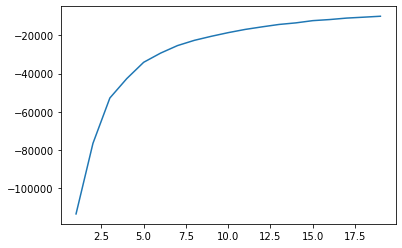

In [18]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [19]:
#define silhouette score

from sklearn.metrics import silhouette_score

def silhouette_score_func(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels, metric='euclidean')

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

n_clusters = range(1, 20)

param_grid = {
    'KMeans__n_clusters': n_clusters, 
}

estimator = Pipeline([('KMeans', KMeans())])

cv = [(slice(None), slice(None))]
grid = GridSearchCV(estimator, 
                    param_grid=param_grid,
                    cv=cv,
                    return_train_score=True,                    
                    scoring=silhouette_score_func)

grid.fit(data)
scores_result_df = pd.concat(
    [pd.DataFrame(grid.cv_results_["params"]),
     pd.DataFrame(grid.cv_results_["mean_train_score"], 
                  columns=["silhouette_score"])],axis=1)

scores_result_df.sort_values(by=['silhouette_score'], ascending=False, inplace=True)
scores_result_df.head(20)

,KMeans__n_clusters,silhouette_score
4,5,0.466361
5,6,0.462721
3,4,0.432073
2,3,0.414638
6,7,0.408796
7,8,0.398655
8,9,0.392070
9,10,0.385936
16,17,0.385219
15,16,0.383744


Berdasarkan elbow method dan silhouette score, optimal number cluster yang disarankan adalah 4

**2. Setelah jumlah cluster ditentukan, maka perlu di apply ke data set**

In [21]:
# Create model of k clusters and train it
kmeans01 = KMeans(n_clusters=4, init='k-means++', random_state=21)
kmeans01.fit(data)

# Get labels and clusters
arr_labels_01 = kmeans01.predict(data).reshape((-1,1))
arr_centroids_01 = kmeans01.cluster_centers_

# Label the data with the predictions in the data frame
data['clusters'] = arr_labels_01.flatten()

data['clusters'].value_counts()

3    9774
2    5870
1    4740
0    2311
Name: clusters, dtype: int64

**3. Mencari jarak setiap point terhadap centroids tiap cluster**

In [22]:
# Get distance to centroid
def get_distance_centroid(array, centroids):
    """
    This function is made to be used with `numpy.apply_along_axis`.Takes in an n-dimensional 
    vector of features (previously processed) and finds the distance to their respective 
    cluster centroid.
    
    * **`array`**: 
    * **`centroids`**:
    """
    vector = array[:-1]
    label = array[-1]
    centroid = centroids[int(label)]
    dist = euclidean(vector, centroid)
    return dist

In [23]:
# Find distance
arr_distances_centroid_01 = np.apply_along_axis(func1d = get_distance_centroid, axis=1,
                                                arr= data,
                                                centroids = arr_centroids_01)
# Add data to data frame
data['distance_centroid'] = arr_distances_centroid_01

data.head()

,0,1,2,3,4,clusters,distance_centroid
0,-0.869973,1.375415,0.709281,-1.484001,0.622342,3,1.783660
1,-0.799515,1.375415,0.709281,-1.484001,0.622342,3,1.737685
2,-0.713073,1.375415,0.709281,-1.484001,0.622342,3,1.683596
3,-0.566379,1.375415,0.709281,-1.484001,0.622342,3,1.598327
4,-0.479876,1.375415,0.709281,-1.484001,0.622342,3,1.552353


**4. Mengetahui distribusi distance centorids menggunakan Modified Z-score**

modified z score digunakan untuk menentukan apakah sebuah data termasuk anomaly atau bukan

In [24]:
# Get distance to centroid (Standardised)
def calculate_modifed_z_score(array, medians, mads):
    """
    This function is made to be used with `numpy.apply_along_axis`. Takes in a 2-dimensional 
    vector of distances and labels and returns their respective Modified Z-score acording to 
    their respective distribution.
    
    * **`array`** (_ndarray_): A vector/array of 2 dimensions where the first element is the 
                               distance to the cluster's centroidlast element and the second 
                               element the label of the category/group/cluster.
                               The label must be in a numeric form starting from 0 up to the 
                               _n-1_ category.
                               The labels must match with the index of their respective elment 
                               in `medians`.
    * **`medians`** (_array like_): A list or ndarray containig the medians of the respective 
                                    distance distribution from each category
    * **`mads`** (_array like_): A list or ndarray contaiing the median absolute deviation from 
                                 the median of the respective distance distribution from each 
                                 category
    """
    distance, label = array
    median = medians[int(label)]
    mad = mads[int(label)]
    z_mod = (distance - median)/mad
    return z_mod

In [25]:
arr_distances_labels_01 = data[['distance_centroid','clusters']].values

In [26]:
median_01_0 = np.median(data.query('clusters == 0')['distance_centroid'].values)
median_01_1 = np.median(data.query('clusters == 1')['distance_centroid'].values)
median_01_2 = np.median(data.query('clusters == 2')['distance_centroid'].values)
median_01_3 = np.median(data.query('clusters == 3')['distance_centroid'].values)
list_medians_01 = [median_01_0, median_01_1, median_01_2, median_01_3]

mads_01_0 = median_abs_deviation(data.query('clusters == 0')['distance_centroid'].values)
mads_01_1 = median_abs_deviation(data.query('clusters == 1')['distance_centroid'].values)
mads_01_2 = median_abs_deviation(data.query('clusters == 2')['distance_centroid'].values)
mads_01_3 = median_abs_deviation(data.query('clusters == 3')['distance_centroid'].values)
list_mads_01 = [mads_01_0, mads_01_1, mads_01_2, mads_01_3]

In [27]:
arr_z_mod_01 = np.apply_along_axis(func1d= calculate_modifed_z_score,
                                   arr= arr_distances_labels_01,
                                   axis = 1,
                                   medians = list_medians_01,
                                   mads = list_mads_01
                                  )

In [28]:
data['z_mod'] = arr_z_mod_01
data.head()

,0,1,2,3,4,clusters,distance_centroid,z_mod
0,-0.869973,1.375415,0.709281,-1.484001,0.622342,3,1.783660,2.708230
1,-0.799515,1.375415,0.709281,-1.484001,0.622342,3,1.737685,2.519522
2,-0.713073,1.375415,0.709281,-1.484001,0.622342,3,1.683596,2.297506
3,-0.566379,1.375415,0.709281,-1.484001,0.622342,3,1.598327,1.947512
4,-0.479876,1.375415,0.709281,-1.484001,0.622342,3,1.552353,1.758808


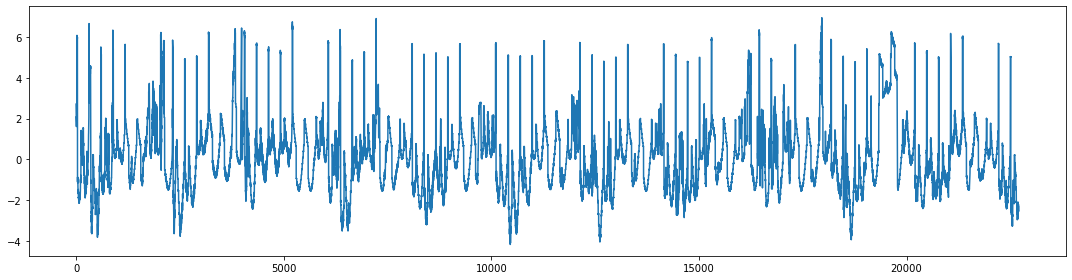

In [29]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(data['z_mod'])
plt.tight_layout()



Berdasarkan plot, kebanyakan data berada pada rentang z-score mod -3.5 hingga 3.5, sehingga data lebih dari itu bisa dianggap sebagai outlier

### LOF (Local Outlier Factor) 

In [30]:
data2 = raw.copy()

In [31]:
# reduce to 2 importants features
pca = PCA(n_components=2)
data2 = pca.fit_transform(data2)

# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data2)
data2 = pd.DataFrame(np_scaled)

In [32]:
data2.head(3)

,0,1
0,-1.143708,-1.212546
1,-1.141072,-1.207525
2,-1.137839,-1.201365


In [33]:
def get_local_outlier_factor_scores(dataframe, k_neighbours = 4):
    """
    """
    X = dataframe.values
    # 1. Create model
    lof_model = LocalOutlierFactor(n_neighbors= k_neighbours)
    # 2. Train the model
    lof_model.fit(X)
    # 3. Get the Local Outlier Factor (score)
    negative_lof = lof_model.negative_outlier_factor_
    dataframe['local_outlier_factor'] = -1 * negative_lof
    return dataframe

In [34]:
get_local_outlier_factor_scores(data2, k_neighbours = 4)

,0,1,local_outlier_factor
0,-1.143708,-1.212546,1.151471
1,-1.141072,-1.207525,1.006490
2,-1.137839,-1.201365,1.024423
3,-1.132351,-1.190911,1.593915
4,-1.129115,-1.184746,0.991479
...,...,...,...
22690,-0.548535,-0.608099,1.027717
22691,-0.549573,-0.610075,1.251135
22692,-0.551392,-0.613542,1.186102
22693,-0.548885,-0.608765,0.948725


[]

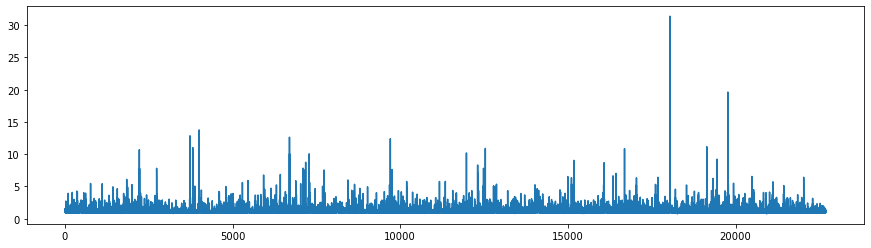

In [35]:
#plot local_outlier_factor to determine treshold
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(data2['local_outlier_factor'])

plt.plot()


Berdasarkan plot, kebanyakan data berada pada rentang LOF 0-6, sehingga data lebih dari itu bisa dianggap sebagai outlier atau anomaly

## Determine Anomaly 

**Syarat Kategori Anomali**
<br> Untuk mengidentifikasi sebuah data termasuk anomali atau tidak, diperlukan treshold untuk menilai tiap matriks. 
 <br>Dalam hal ini, kita menggunakan: 
   <br> 1. K-Means: z-mod >3.5 merupakan outlier (nilainya jauh dari median)
   <br>2. Local Outlier Factor (LOF): LOF score > 6

<br> **Menentukan kategori anomali/outlier?**
<br>Outlier dapat langsung diidentifikasi melalui LOF score, namun tidak untuk k-means. Dari K-means, nilai z-mod didapat dari tiap centroid cluster, sehingga prespektif anomali seharusnya berdasarkan setiap cluster. 

In [36]:
def detect_anomaly(value, threshold, detector):
    if detector == 'z_mod':
        if value > threshold:
            return 'Outlier'
        else: 
            return 'Inlier'
    elif detector == 'lof':
        if value > threshold:
            return 'Outlier'
        else: 
            return 'Inlier'

In [37]:
# Detect outliers -> K-Means
data['outliers_z_mod'] = data['z_mod'].apply(detect_anomaly, args = (3.5, 'z_mod',))

# Detect outliers -> LOF
data2['outliers_lof'] = data2['local_outlier_factor'].apply(detect_anomaly, args = (6, 'lof',))

## Visualization

### Visualization k-means clustering

In [38]:
data['principal_feature1'] = data[0]
data['principal_feature2'] = data[1]
data['clusters'].value_counts()

3    9774
2    5870
1    4740
0    2311
Name: clusters, dtype: int64

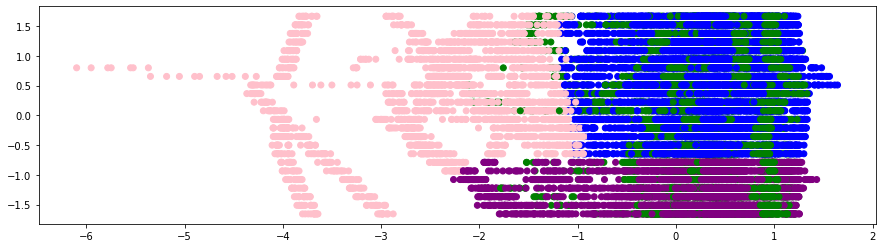

In [39]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize = (15,4))
colors = {0:'pink', 1:'purple', 2:'green', 3:'blue'}
ax.scatter(data['principal_feature1'], data['principal_feature2'], c=data['clusters'].apply(lambda x: colors[x]))
plt.show()

In [40]:
kmeansvis= pd.concat([df, data], axis = 1, join = 'inner')
display(kmeansvis)

,timestamp,value,year,month,day,hour,minute,dayofweek,daylight,weekday,...,1,2,3,4,clusters,distance_centroid,z_mod,outliers_z_mod,principal_feature1,principal_feature2
0,2013-12-02 21:15:00,23.315179,2013,12,2,21,15,0,1,1,...,1.375415,0.709281,-1.484001,0.622342,3,1.783660,2.708230,Inlier,-0.869973,1.375415
1,2013-12-02 21:20:00,23.853268,2013,12,2,21,20,0,1,1,...,1.375415,0.709281,-1.484001,0.622342,3,1.737685,2.519522,Inlier,-0.799515,1.375415
2,2013-12-02 21:25:00,24.513423,2013,12,2,21,25,0,1,1,...,1.375415,0.709281,-1.484001,0.622342,3,1.683596,2.297506,Inlier,-0.713073,1.375415
3,2013-12-02 21:30:00,25.633726,2013,12,2,21,30,0,1,1,...,1.375415,0.709281,-1.484001,0.622342,3,1.598327,1.947512,Inlier,-0.566379,1.375415
4,2013-12-02 21:35:00,26.294353,2013,12,2,21,35,0,1,1,...,1.375415,0.709281,-1.484001,0.622342,3,1.552353,1.758808,Inlier,-0.479876,1.375415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,2014-02-19 15:05:00,36.769675,2014,2,19,15,5,2,1,1,...,0.508956,0.709281,-0.481638,0.622342,3,0.594138,-2.174278,Inlier,0.891777,0.508956
22691,2014-02-19 15:10:00,36.557871,2014,2,19,15,10,2,1,1,...,0.508956,0.709281,-0.481638,0.622342,3,0.567210,-2.284805,Inlier,0.864044,0.508956
22692,2014-02-19 15:15:00,36.186371,2014,2,19,15,15,2,1,1,...,0.508956,0.709281,-0.481638,0.622342,3,0.520184,-2.477828,Inlier,0.815399,0.508956
22693,2014-02-19 15:20:00,36.698251,2014,2,19,15,20,2,1,1,...,0.508956,0.709281,-0.481638,0.622342,3,0.585049,-2.211584,Inlier,0.882425,0.508956


In [41]:
kmeansvis.sample(3)

,timestamp,value,year,month,day,hour,minute,dayofweek,daylight,weekday,...,1,2,3,4,clusters,distance_centroid,z_mod,outliers_z_mod,principal_feature1,principal_feature2
5545,2013-12-22 03:20:00,30.195824,2013,12,22,3,20,6,0,0,...,-1.223961,-1.409878,1.523088,-1.606833,2,1.919644,1.274949,Inlier,0.030988,-1.223961
13482,2014-01-18 15:45:00,28.954007,2014,1,18,15,45,5,1,0,...,0.508956,0.709281,1.021907,-1.606833,2,0.971411,-1.009500,Inlier,-0.131617,0.508956
1684,2013-12-08 17:35:00,23.374565,2013,12,8,17,35,6,1,0,...,0.797776,0.709281,1.523088,-1.606833,2,1.552881,0.391357,Inlier,-0.862197,0.797776


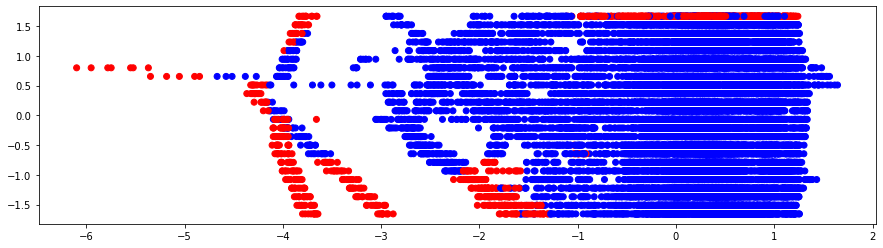

In [42]:
# visualisation of anomaly with k-means cluster view
fig, ax = plt.subplots(figsize = (15,4))
colors = {'Inlier':'blue', 'Outlier':'red'}
ax.scatter(kmeansvis['principal_feature1'], kmeansvis['principal_feature2'], c=kmeansvis['outliers_z_mod'].apply(lambda x: colors[x]))
plt.show()

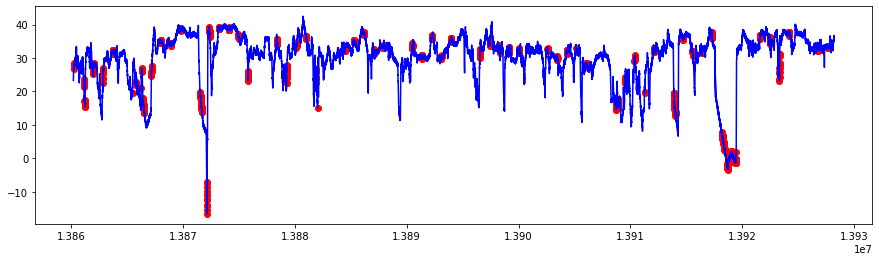

In [43]:
# visualisation of anomaly throughout time (viz k-means clustering)
fig, ax = plt.subplots(figsize = (15,4))

a = kmeansvis.loc[kmeansvis['outliers_z_mod'] == 'Outlier', ['time_epoch', 'value']] #anomaly

ax.plot(kmeansvis['time_epoch'], kmeansvis['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

### Visualization LOF

In [44]:
data2['principal_feature1'] = data[0]
data2['principal_feature2'] = data[1]

In [45]:
data2

,0,1,local_outlier_factor,outliers_lof,principal_feature1,principal_feature2
0,-1.143708,-1.212546,1.151471,Inlier,-0.869973,1.375415
1,-1.141072,-1.207525,1.006490,Inlier,-0.799515,1.375415
2,-1.137839,-1.201365,1.024423,Inlier,-0.713073,1.375415
3,-1.132351,-1.190911,1.593915,Inlier,-0.566379,1.375415
4,-1.129115,-1.184746,0.991479,Inlier,-0.479876,1.375415
...,...,...,...,...,...,...
22690,-0.548535,-0.608099,1.027717,Inlier,0.891777,0.508956
22691,-0.549573,-0.610075,1.251135,Inlier,0.864044,0.508956
22692,-0.551392,-0.613542,1.186102,Inlier,0.815399,0.508956
22693,-0.548885,-0.608765,0.948725,Inlier,0.882425,0.508956


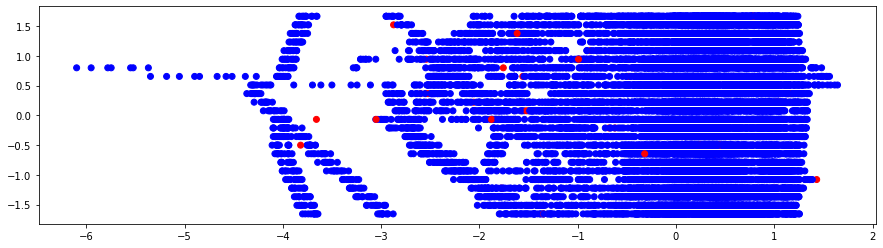

In [46]:
# visualisation of anomaly with LOF cluster view
fig, ax = plt.subplots(figsize = (15,4))
colors = {'Inlier':'blue', 'Outlier':'red'}
ax.scatter(data2['principal_feature1'], data2['principal_feature2'], c=data2['outliers_lof'].apply(lambda x: colors[x]))
plt.show()

In [47]:
lofvis= pd.concat([df, data2], axis = 1, join = 'inner')
display(lofvis)

,timestamp,value,year,month,day,hour,minute,dayofweek,daylight,weekday,time_epoch,categories,0,1,local_outlier_factor,outliers_lof,principal_feature1,principal_feature2
0,2013-12-02 21:15:00,23.315179,2013,12,2,21,15,0,1,1,13860189,3,-1.143708,-1.212546,1.151471,Inlier,-0.869973,1.375415
1,2013-12-02 21:20:00,23.853268,2013,12,2,21,20,0,1,1,13860192,3,-1.141072,-1.207525,1.006490,Inlier,-0.799515,1.375415
2,2013-12-02 21:25:00,24.513423,2013,12,2,21,25,0,1,1,13860195,3,-1.137839,-1.201365,1.024423,Inlier,-0.713073,1.375415
3,2013-12-02 21:30:00,25.633726,2013,12,2,21,30,0,1,1,13860198,3,-1.132351,-1.190911,1.593915,Inlier,-0.566379,1.375415
4,2013-12-02 21:35:00,26.294353,2013,12,2,21,35,0,1,1,13860201,3,-1.129115,-1.184746,0.991479,Inlier,-0.479876,1.375415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,2014-02-19 15:05:00,36.769675,2014,2,19,15,5,2,1,1,13928223,3,-0.548535,-0.608099,1.027717,Inlier,0.891777,0.508956
22691,2014-02-19 15:10:00,36.557871,2014,2,19,15,10,2,1,1,13928226,3,-0.549573,-0.610075,1.251135,Inlier,0.864044,0.508956
22692,2014-02-19 15:15:00,36.186371,2014,2,19,15,15,2,1,1,13928229,3,-0.551392,-0.613542,1.186102,Inlier,0.815399,0.508956
22693,2014-02-19 15:20:00,36.698251,2014,2,19,15,20,2,1,1,13928232,3,-0.548885,-0.608765,0.948725,Inlier,0.882425,0.508956


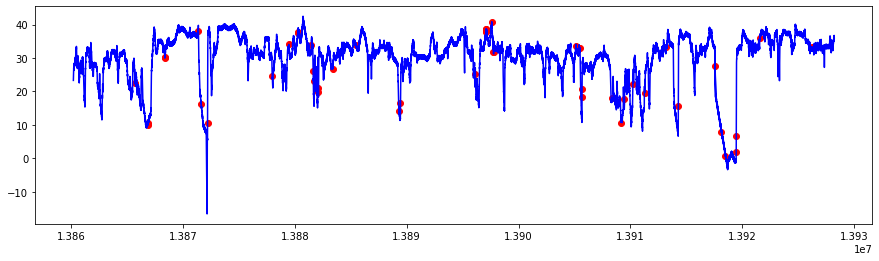

In [48]:
# visualisation of anomaly throughout time (viz lof)
fig, ax = plt.subplots(figsize = (15,4))

a = lofvis.loc[lofvis['outliers_lof'] == 'Outlier', ['time_epoch', 'value']] #anomaly

ax.plot(lofvis['time_epoch'], lofvis['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

## Supervised Learning

In [49]:
data.sample(3)

,0,1,2,3,4,clusters,distance_centroid,z_mod,outliers_z_mod,principal_feature1,principal_feature2
21154,0.941176,-0.646322,0.709281,0.520725,0.622342,3,1.659316,2.197847,Inlier,0.941176,-0.646322
13963,0.306479,-0.646322,0.709281,-1.484001,0.622342,3,1.550938,1.752999,Inlier,0.306479,-0.646322
14551,-0.420916,-0.501912,0.709281,-0.481638,0.622342,3,1.265883,0.582966,Inlier,-0.420916,-0.501912


In [50]:
data2.sample(3)

,0,1,local_outlier_factor,outliers_lof,principal_feature1,principal_feature2
18749,-0.572512,-1.212845,0.937490,Inlier,0.239976,1.519825
15334,1.371921,1.504898,0.970313,Inlier,-0.354534,-1.368371
20926,-0.283456,-0.367801,0.997803,Inlier,0.903685,0.075727


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_classification(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    
    print("Accuracy (Test Set): %.3f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.3f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.3f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.3f" % precision_score(y_train, y_pred_train))
    print("Recall (Test Set): %.3f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.3f" % recall_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.3f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.3f" % f1_score(y_train, y_pred_train))
    print("ROC_AUC (test-proba): %.3f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("ROC_AUC (train-proba): %.3f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

### Semi Supervised K-Means Clustering

In [53]:
#Train test split data k-means clustering

data['outliers_z_mod_flag'] = np.where(data['outliers_z_mod']=='Outlier',1,0)

In [60]:
data

,0,1,2,3,4,clusters,distance_centroid,z_mod,outliers_z_mod,principal_feature1,principal_feature2,outliers_z_mod_flag
0,-0.869973,1.375415,0.709281,-1.484001,0.622342,3,1.783660,2.708230,Inlier,-0.869973,1.375415,0
1,-0.799515,1.375415,0.709281,-1.484001,0.622342,3,1.737685,2.519522,Inlier,-0.799515,1.375415,0
2,-0.713073,1.375415,0.709281,-1.484001,0.622342,3,1.683596,2.297506,Inlier,-0.713073,1.375415,0
3,-0.566379,1.375415,0.709281,-1.484001,0.622342,3,1.598327,1.947512,Inlier,-0.566379,1.375415,0
4,-0.479876,1.375415,0.709281,-1.484001,0.622342,3,1.552353,1.758808,Inlier,-0.479876,1.375415,0
...,...,...,...,...,...,...,...,...,...,...,...,...
22690,0.891777,0.508956,0.709281,-0.481638,0.622342,3,0.594138,-2.174278,Inlier,0.891777,0.508956,0
22691,0.864044,0.508956,0.709281,-0.481638,0.622342,3,0.567210,-2.284805,Inlier,0.864044,0.508956,0
22692,0.815399,0.508956,0.709281,-0.481638,0.622342,3,0.520184,-2.477828,Inlier,0.815399,0.508956,0
22693,0.882425,0.508956,0.709281,-0.481638,0.622342,3,0.585049,-2.211584,Inlier,0.882425,0.508956,0


In [54]:
ct12 = data.drop(['outliers_z_mod'], axis = 1)

In [61]:
X = ct12.iloc[:,:-1]
y = ct12['outliers_z_mod_flag']

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 21)

In [65]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

eval_classification(logreg, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.999
Accuracy (Train Set): 1.000
Precision (Test Set): 0.997
Precision (Train Set): 1.000
Recall (Test Set): 0.989
Recall (Train Set): 0.992
F1-Score (Test Set): 0.993
F1-Score (Train Set): 0.996
ROC_AUC (test-proba): 1.000
ROC_AUC (train-proba): 1.000


### Semi supervised LOF

In [66]:
#Train test split data LOF

data2['outliers_lof_flag'] = np.where(data2['outliers_lof']=='Outlier',1,0)

In [67]:
ct22 = data2.drop(['outliers_lof'], axis = 1)

In [68]:
ct22.head(3)

,0,1,local_outlier_factor,principal_feature1,principal_feature2,outliers_lof_flag
0,-1.143708,-1.212546,1.151471,-0.869973,1.375415,0
1,-1.141072,-1.207525,1.006490,-0.799515,1.375415,0
2,-1.137839,-1.201365,1.024423,-0.713073,1.375415,0


In [69]:
ct22['outliers_lof_flag'].value_counts()

0    22647
1       48
Name: outliers_lof_flag, dtype: int64

In [70]:
X = ct22.drop(labels = ['outliers_lof_flag'], axis = 1)
y = ct22['outliers_lof_flag']

In [71]:
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(22695, 5) (22695,)
(15886, 10) (6809, 10) (15886,) (6809,)


In [72]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

eval_classification(logreg, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.999
Accuracy (Train Set): 1.000
Precision (Test Set): 0.997
Precision (Train Set): 1.000
Recall (Test Set): 0.989
Recall (Train Set): 0.992
F1-Score (Test Set): 0.993
F1-Score (Train Set): 0.996
ROC_AUC (test-proba): 1.000
ROC_AUC (train-proba): 1.000


## Kesimpulan

1. Metode k-means clustering dapat mendetekssi outlier lebih banyak daripada LOF
2. Supervised learning dapat di combine dengan unsupervised learning untuk mendeteksi outlier, dengan cara mengambil label outlier dari hasil unsupervised learning